# Maxie Tutorial

This tutorial demonstrates how to use MAXIE - the
[Masked Autoencoder for X-ray Image Encoding (MAXIE)](https://github.com/carbonscott/maxie/).
We start with loading images from PSana data source, and then load a trained
model and run images through the model to infer complete, reconstructed images.

## Preamble

In [1]:
!pwd

/gpfs/alpine2/lrn044/proj-shared/foundation_models/results/demo/train/analysis


In [2]:
# Run the notebook as if it's in the PROJECT directory
%bookmark PROJ_ROOT /gpfs/alpine2/lrn044/proj-shared/foundation_models/results/demo/train/
%cd -b PROJ_ROOT

(bookmark:PROJ_ROOT) -> /gpfs/alpine2/lrn044/proj-shared/foundation_models/results/demo/train/
/gpfs/alpine2/lrn044/proj-shared/foundation_models/results/demo/train


### Psana environment

In [3]:
from maxie.datasets.psana_utils import PsanaImg

### Matplotlib

In [4]:
import matplotlib.pyplot       as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
import matplotlib.font_manager as font_manager
%matplotlib inline

### Packages

In [5]:
import numpy as np
from math import sqrt
import os
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F

### Display functions

In [6]:
def display_img(img, scale = 7):
    ncols, nrows = 1, 1
    fig   = plt.figure(figsize = (ncols * scale, nrows * scale))
    gspec = fig.add_gridspec( nrows, ncols )
    ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

    ax = ax_list[0]

    vmin = np.mean(img) - 0 * img.std()
    vmax = np.mean(img) + 4 * img.std()
    im = ax.imshow(img, vmin = vmin, vmax = vmax)

    return fig

def display_patches(patches, figsize = (8, 8)):
    N, H, W = patches.shape
    ndiv = int(sqrt(N))
    ncols = ndiv
    nrows = ndiv
    fig   = plt.figure(figsize = figsize)
    gspec = fig.add_gridspec( nrows, ncols, )
    ax_list = [ fig.add_subplot(gspec[i, j], aspect = 1) for i in range(nrows) for j in range(ncols)]

    vmin = np.mean(patches) - 0 * patches.std()
    vmax = np.mean(patches) + 4 * patches.std()
    for row in range(nrows):
        for col in range(ncols):
            idx = col + ncols * row
            ax = ax_list[idx]
            # data_viz = patches[row][col]
            data_viz = patches[idx]
            ax.imshow(data_viz, interpolation = 'none', vmin = vmin, vmax = vmax)

    # Apply style...
    for ax in ax_list:
        ax.set_xticks([])
        ax.set_yticks([])

        # Hide the frame box
        ax.spines['top'   ].set_visible(False)
        ax.spines['right' ].set_visible(False)
        ax.spines['left'  ].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    return fig

In [7]:
fl_yaml = "experiments/yaml/mfxx49820_cfg0.yaml"
with open(fl_yaml, 'r') as fh:
    config = yaml.safe_load(fh)

## Data

### Exp - mfxlx5520

In [8]:
exp           = 'mfxx49820'
run           = 100
img_load_mode = 'image'
access_mode   = 'idx'
detector_name = 'epix10k2M'

psana_img = PsanaImg(exp, run, access_mode, detector_name)
# mask_bad_pixel = psana_img.create_bad_pixel_mask()

In [9]:
event = 450
img = psana_img.get(event, None, img_load_mode)
img.shape

(1666, 1664)

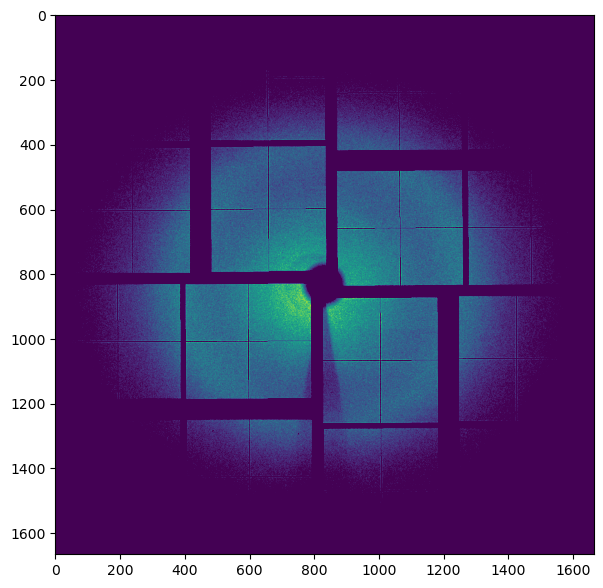

In [10]:
# img[:10, :] = 0
# img[:, :10] = 0
# img[-10:, :] = 0
# img[:, -10:] = 0
fig_orig = display_img(img)

### Set up transforms

Next, we'll use MAXIE's data transformation pipeline to scale, pad, shift, and create patches the first image. The resulting image patches will be what the vision transformer model will see as its input.

In [11]:
from maxie.tensor_transforms import Pad, DownscaleLocalMean, RandomPatch, RandomRotate, RandomShift, Patchify, Norm

In [12]:
dataset_config       = config.get("dataset")
transforms_config    = dataset_config.get("transforms")
num_patch            = transforms_config.get("num_patch")
size_patch           = transforms_config.get("size_patch")
frac_shift_max       = transforms_config.get("frac_shift_max")
angle_max            = transforms_config.get("angle_max")
var_size_patch       = transforms_config.get("var_size_patch")
downscale_factors    = transforms_config.get("downscale_factors")
H_pad                = transforms_config.get("H_pad")
W_pad                = transforms_config.get("W_pad")
patch_size           = transforms_config.get("patch_size")
stride               = transforms_config.get("stride")
detector_norm_params = transforms_config.get("norm")

In [13]:
transforms = (
    Norm(detector_norm_params),
    Pad(H_pad, W_pad),
    ## DownscaleLocalMean(factors = downscale_factors),
    ## RandomPatch(num_patch = num_patch, H_patch = size_patch, W_patch = size_patch, var_H_patch = var_size_patch, var_W_patch = var_size_patch, returns_mask = False),
    ## RandomRotate(angle_max),
    RandomShift(frac_y_shift_max=frac_shift_max, frac_x_shift_max=frac_shift_max),
    Patchify(patch_size, stride),
)

In [14]:
def apply_transforms(image, transforms, detector_name):
    image_tensor = None
    if image is not None and transforms is not None:
        image_tensor = torch.from_numpy(image[None, None])  # (B=1, C, H, W)
        for enum_idx, trans in enumerate(transforms):
            image_tensor = trans(image_tensor, detector_name=detector_name)
        B, N, C, H, W = image_tensor.shape    # (B=1, num_patches, C, patch_size, patch_size)
        image_tensor = image_tensor.view(B*N, C, H, W)

    return image_tensor

In [15]:
img_tensor = apply_transforms(img, transforms, detector_name)
B, C, H, W = img_tensor.shape

### Transform original to MAE input

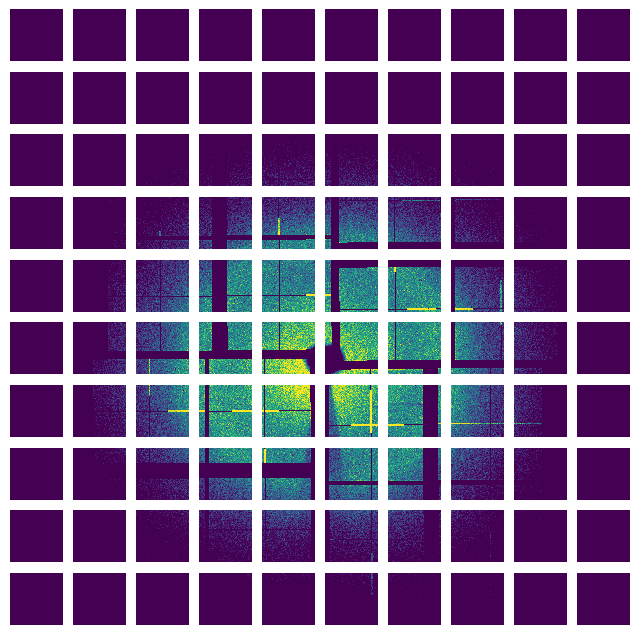

In [16]:
img_tensor_viz = img_tensor.view(B*C, H, W).numpy()
patch_orig = display_patches(img_tensor_viz)

## Model Prediction

### Read checkpoint

In [17]:
dir_chkpt = "experiments/chkpts"

# file_chkpt = "mfxx49820_cfg0.2024_0602_1633_23.epoch_0.end_idx_102600"
file_chkpt = "mfxx49820_cfg1.2024_0603_2030_35.preempt"

path_chkpt = os.path.join(dir_chkpt, file_chkpt)

chkpt = torch.load(path_chkpt, map_location="cpu")

In [18]:
chkpt.keys()

dict_keys(['model_state_dict', 'optim_state_dict', 'scheduler_state_dict', 'training_state_dict'])

In [19]:
model_state_dict = chkpt.get('model_state_dict')

### Init model

Here we setup an adapted version of the [Vision Transformer (ViT)](https://huggingface.co/facebook/vit-mae-base) pre-trained using the MAE method from the paper [Masked Autoencoders Are Scalable Vision Learners](https://arxiv.org/abs/2111.06377) by Kaiming He, Xinlei Chen, Saining Xie, Yanghao Li, Piotr Dollár, Ross Girshick and released for pytorch-GPU in [this repository](https://github.com/facebookresearch/mae).

In [20]:
from maxie.modeling.adapted_mae import AdaptedViTMAEForPreTrainingConfig, AdaptedViTMAEForPreTraining

/gpfs/alpine2/lrn044/proj-shared/foundation_models/sw/miniforge3/envs/myfms/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
model_params = config.get("model")
model_name   = model_params.get("name")
mask_ratio   = model_params.get("mask_ratio")

In [22]:
# -- Config the model
model_config = AdaptedViTMAEForPreTrainingConfig(
    model_name = model_name,
    mask_ratio = mask_ratio,
)
model = AdaptedViTMAEForPreTraining(model_config)

Updating patch_embeddings num_channels from 3 to 1


In [23]:
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [24]:
model.eval();

### Eval

In [25]:
with torch.no_grad():
    output_tensor = model(img_tensor)

In [26]:
output_tensor.keys()

odict_keys(['loss', 'logits', 'mask', 'ids_restore'])

In [27]:
output_tensor['mask'].shape  # (10 * 10, 14 * 14)

torch.Size([100, 196])

How to obtain predicted pixels?  Refer to https://github.com/huggingface/transformers/blob/96eb06286b63c9c93334d507e632c175d6ba8b28/src/transformers/models/vit_mae/modeling_vit_mae.py#L1146

In [28]:
B, P, HW = output_tensor.logits.shape  # (B, P, 1 * 16 * 16)
B, P, HW

(100, 196, 256)

In [29]:
H, W = int(sqrt(HW)), int(sqrt(HW))
num_patch_in_field = int(sqrt(P))
logits = output_tensor.logits.view(B, num_patch_in_field, num_patch_in_field, H, W) \
                             .permute(0, 1, 3, 2, 4) \
                             .contiguous() \
                             .view(B, num_patch_in_field * H, num_patch_in_field * W)
logits.shape

torch.Size([100, 224, 224])

(num_patches, channels, patch_height, patch_width)

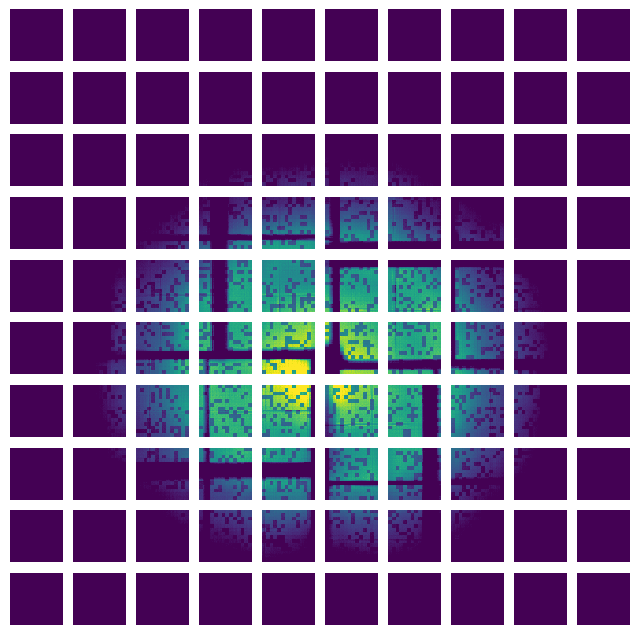

In [30]:
patch_pred = display_patches(logits.numpy())

In [31]:
# patch_pred.savefig("patch_pred.pdf", dpi=300, transparent=True)

### Retrieve the masked input

In [32]:
mask = output_tensor.mask.view(B, num_patch_in_field, num_patch_in_field).bool()
mask.shape

torch.Size([100, 14, 14])

In [33]:
img_tensor.view(100, 224, 224).shape

torch.Size([100, 224, 224])

In [34]:
img_tensor \
.view(100, num_patch_in_field, H, num_patch_in_field, W) \
.permute(0, 1, 3, 2, 4) \
.contiguous() \
.shape

torch.Size([100, 14, 14, 16, 16])

In [35]:
img_tensor_mod = img_tensor \
.view(100, num_patch_in_field, H, num_patch_in_field, W) \
.permute(0, 1, 3, 2, 4) \
.contiguous()

In [36]:
img_tensor_mod[mask] = 0

In [37]:
img_tensor_mod = img_tensor_mod.permute(0, 1, 3, 2, 4) \
                             .contiguous() \
                             .view(B, num_patch_in_field * H, num_patch_in_field * W)

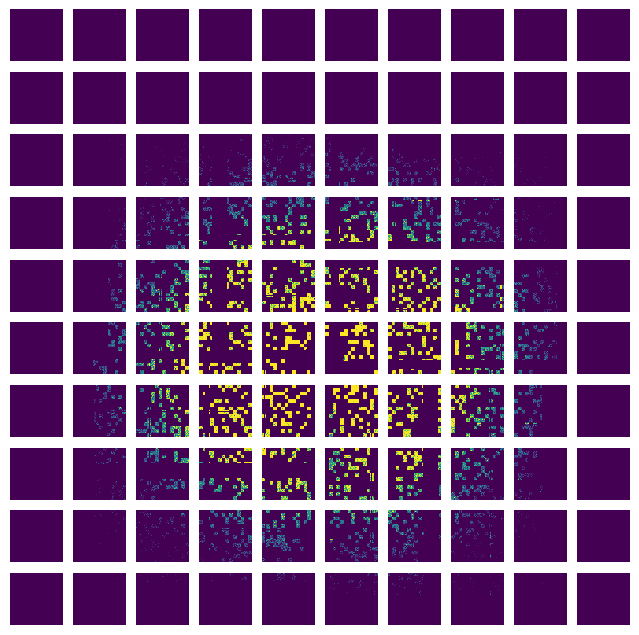

In [38]:
patch_masked = display_patches(img_tensor_mod.numpy())

In [39]:
# patch_masked.savefig("patch_masked.pdf", dpi=300, transparent=True)

### Recap

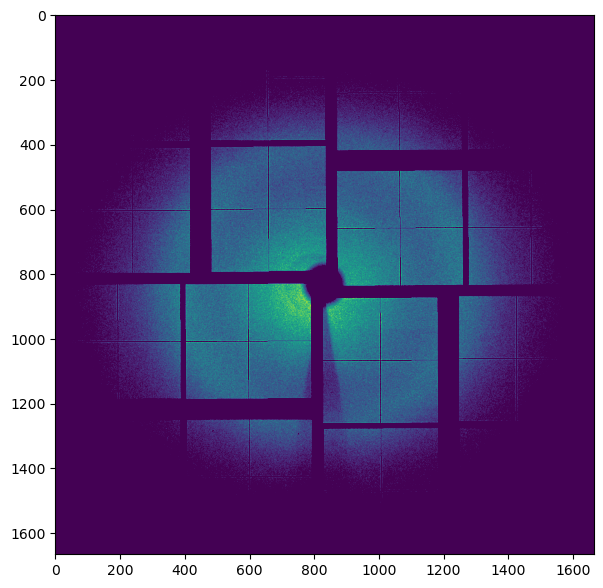

In [40]:
fig_orig = display_img(img)

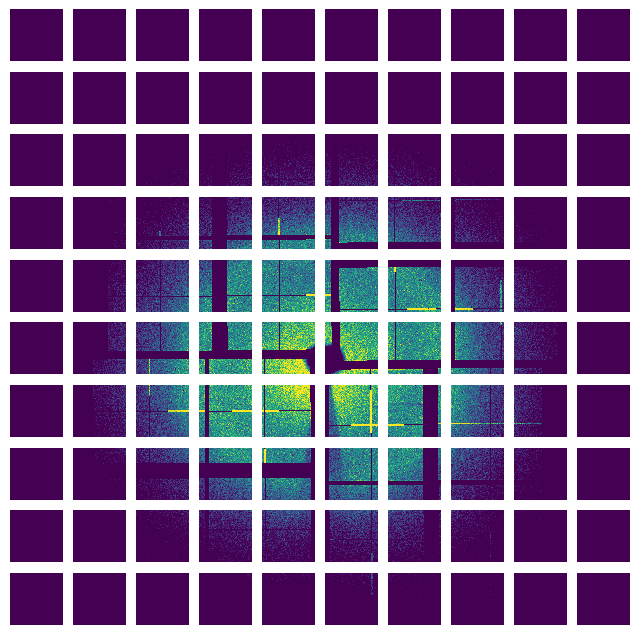

In [42]:
patch_orig = display_patches(img_tensor_viz)

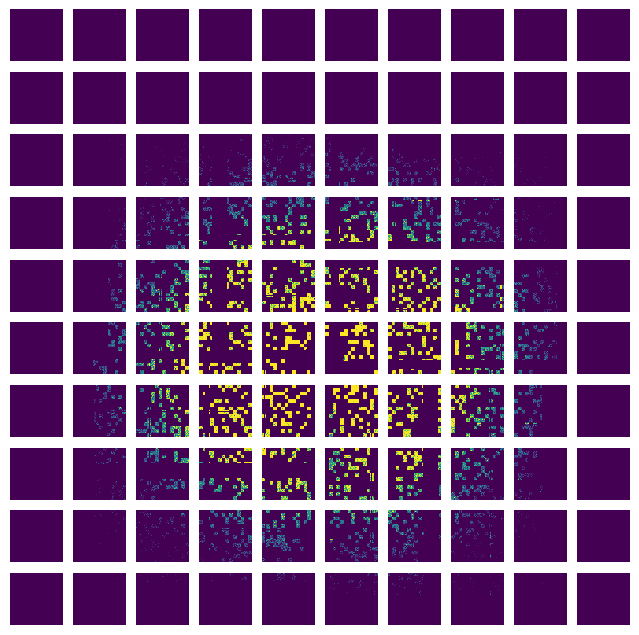

In [43]:
patch_masked = display_patches(img_tensor_mod.numpy())

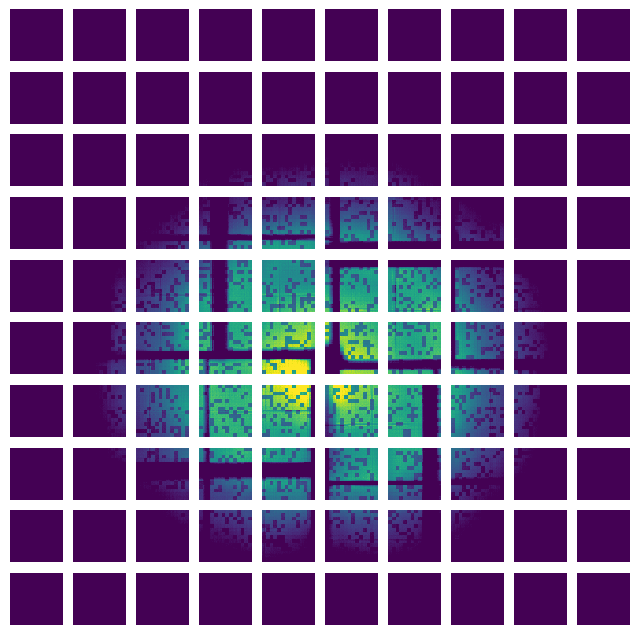

In [44]:
patch_pred = display_patches(logits.numpy())